# Optimal Bidding on the First Round of Wizard
Nick Holden

### Overview
Wizard is a trick-taking card game, played with a normal 52 card deck with the addition of four "Jester" cards, and four "Wizard" cards. Wizard forces players to make judgment calls with imperfect information on how many tricks they can take, and tests the players' abilities to successfully make their bids. 

As players have more cards in their hands, they have more control over how the cards are played. Therefore better players have more of an advantage as hand sizes grow. However in the first round where everyone has exactly one card, players have no control over their gameplay, so bidding becomes an exercise in statistics rather than game knowledge.

In this project, we determine a first round bidding strategy that maximizes the bidder's expected points. 

### Gameplay
At the start of each round, all players are dealt a varying number of cards (some integer between 1 and $\frac{59}{n}$ cards), and one more card from the deck is flipped face up to determine a trump suit. The trump suit is the suit of the upturned card if a Wizard is flipped over the trump suit is the dealer's choice and if a Jester is flipped over there is no trump suit.


Once players are dealt their hands and a trump suit is determined, the dealer then starts off the bidding phase by looking at his hand and publicly announce how many tricks they believe they can take. The bidding then moves left and ends with the player to the right of the dealer. 


Once every player has bid the dealer starts off the play by leading a card from their hand. Players must follow suit if they can, but they have the option to play a Wizard or a Jester at any time. Once every player has played one card,  the "trick" is assigned by the following hierarchy: 
* To the player who played the first Wizard
* If no Wizards were played, the player who played the highest card in the trump suit (A > K ... > 2) 
* If no Wizards or trump, the player who played the highest card in the led suit
* If only Jesters were played, then the trick is assigned to the player who played the first Jester. 

The player who took the most recent trick obtains the lead for the next trick. Once all of the cards have been played, players are scored for the round based on how close they were to their bid. 
* If the player bid correctly, they are awarded 20 points plus 10 points for each trick they took. For example, if a player bid 3 and made 3, they would be awarded $20 + 3 * 10 = 50$ points
* If the player bid incorrectly, they lose 10 points for each card they are off by. If a player bid 3 and made 1, they would lose $2 * 10 = 20$ points (or gain -20 points). 

At the end of the game, players' scores for each round are totaled and the player with the highest score wins. 

## Discussion
The gameplay for this game is quite complicated when players have multiple cards and there are many nuanced plays that only players with good game sense and experience can see. However, the round with only one card is much easier to optimize because there are no gameplay considerations, only bidding. In this blog post, I will determine an optimal bidding strategy for the round with 1 card for different positions relative to the dealer. I will also show how this strategy changes when playing with a different number of players. 

Since every player wants to maximize their score, the optimal strategy in the first round clearly is to maximize the expected number of points a player will earn. Since there is only one trick, a player must decide between bidding 0 or 1. The payoff matrix is as follows: 


In [7]:
df

,Make 0,Make 1
bet = 0,20,-10
bet = 1,-10,30


As we can see the payoff for betting 1 is higher than the payoff for betting 0. We still expect the optimal solution will lean towards betting one if the probability of winning is near 50%. Let p be the probability of winning, $E[bet = 1] = p * 30 + -10 * (1-p) = 40p - 10$ and  $E[bet = 0] = 20(1-p) + -10p = 20 - 30p$. Since we want to maximize our expectation, we will bet 0 if $20 - 30p < 40p - 10$ and 1 otherwise. The decision boundary, the point where we will change our bid, is given by $p = \frac{3}{7}$

So for any player, if $p > \frac{3}{7}$ they bet 1, otherwise they bet 0. 

It's clear that $p = \frac{3}{7}$ is the inflection point when we plot the expectation of both bids as a function of p:


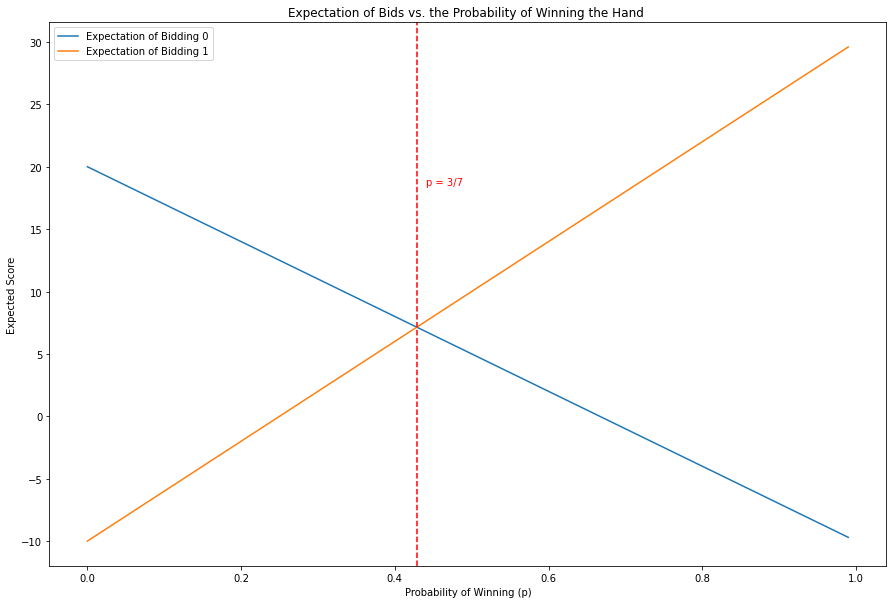

In [10]:
p = pd.Series(range(0,100)) /100
ebid1 = 40 * p - 10
ebid0 = 20 - 30 * p
plt.figure(figsize=(15,10))

plt.plot(p,ebid0)
plt.plot(p,ebid1)
plt.title("Expectation of Bids vs. the Probability of Winning the Hand ")
plt.ylabel("Expected Score")
plt.xlabel("Probability of Winning (p)")
plt.axvline(x=3/7, color='r', linestyle='--')
plt.annotate('p = 3/7', xy=(.45, .7), xycoords='axes fraction', c = 'r')
plt.legend(["Expectation of Bidding 0", "Expectation of Bidding 1"])
plt.show()

As we can see, expectation is maximized when we bid 0 if $p < \frac{3}{7}$ and bid 1 if $p > \frac{3}{7}$. Our goal for determining optimal bidding strategy is calculating a player's probability of winning given the cards in their hand and coming up with a decision boundary for which they bid one if they have cards stronger than that boundary, and 0 otherwise. 

I will calculate one example to show how probability is calculated, then the rest of the probabilities will be calculated procedurally through code. 

Lets say we are playing on a table with 3 other players, and we are the dealer. Lets say we are dealt the 2 of clubs, and the 3 of diamonds is face up so diamonds are trump. Aside from a Jester, we have been dealt the worst possible card, and we can only win if no other players have a wizard, a trump card, or a higher club. Our probability of winning is calculated as follows: There are 12 + 4 + 12 = 28 cards that beat our led card (12 higher clubs, 12 trump cards, and 4 wizards), so the odds the other players don't have any of those cards (this is our probability of winning) is given by:  $p = 1 - \frac{58 - 28}{58} * \frac{58 - 28}{57} * \frac{58 - 28}{56} \approx 0.854 = 85.4$% So our off-trump 2 is likley a loser, and we bet 0.

My code determines the decision boundary through a similar method: it finds the probability of each card winning, and takes the card just above $\frac{3}{7}$ This gives the first card we can bid 1 on. 

In [198]:
plot_decision_boundary_1(14) #15 players

Optimal Dealer Bid Decision Boundary


,Decision Boundary,Card Value
Number of Players,,
2,28.0,2 of Not-Trump
3,19.0,Jack of Not-Trump
4,14.0,4 of Trump
5,10.0,8 of Trump
6,8.0,10 of Trump
7,7.0,Jack of Trump
8,6.0,Queen of Trump
9,5.0,King of Trump
10,4.0,Ace of Trump


We can now generalize this line of thinking to any seat at the table with a couple of adjustments. Because we don't control the led card, we can only bid 1 with trump or better. This is because if the dealer has a different suit than us (which is highly likely) we automatically lose the trick if our hand does not contain trump, no matter how strong our Not-Trump card is. The second adjustment is the bidding of other players. Since we have developed an algorithm for the dealer to bid optimally, their bid conveys information about their hand. If they bid 0, then we know their hand is weaker than the decision boundary card, and conversly if they bid 1 we know that the dealer can have a limited number of cards. We call this "range" of the dealer's possible holdings given their bid "the dealer's range." Below we develop algorithms for calculating the optimal bid given the previous bids before us and our hand. 


* **Case 1: The dealer bids 0.** Since we know the decision boundary for the dealer, we know we know they saw none of the cards better than the decision boundary. So off the bat, we know *all trump cards greater than the decision boundary will be included in dealer +1's decision boundary.*  Let d be the decision boundary for the dealer. If we are sitting at dealer + 1, our probability of winning is the probability we beat the dealer, times the probability we beat everyone after us. So $p \approx p($Beat Dealer$,card) * p(n-1,card)$ where $p(n-1,card)$ is the probability of winning as a dealer at a table with n-1 players with $card$ in their hand. Since $p($Beat Dealer$,card)$ is greater than just any random player (we know the dealer is weaker than average when they bid 0 because their "range" of holdings is capped), we expect the dealer +1 decision boundary to be bounded above by the dealer's decision boundary (assuming both are trump). Our probability of winning can be calculated algorithmically:
    * If our card is stronger than the top of the dealers range, and our card is trump, then we beat the dealer with probability 1. We calculate the probability for beating every other player similar to above with p(beating everyone else) = $\Pi^{n -1}_{i = 1} \frac{58 - i - c}{58 - i}$ where c is relative strength of our card. (ie c = # cards in the deck that beat our card). 
    * If our card is weaker than the top of the dealers range. Then our probability of beating the dealer is the fraction of cards in his or her range that beat our card. This is given by $\frac{58 - (d - c)}{58 - d}$  Where d is the relative strength of the top of the dealers decision boundary, and c is the strength of our card. The probability of beating the remaining players is the same as above. (Technically the non-dealer hands are a tiny bit weaker/stronger depending on the dealers bid, but this is so negligable that it will never change the optimal card). 
    

In [202]:
plot_decision_boundary2(12,2)

Optimal decision boundary if all previous players bid 0


,Dealer,Dealer + 1
Number of Players,,
2,2 of Not-Trump,2 of Trump
3,Jack of Not-Trump,3 of Trump
4,4 of Trump,3 of Trump
5,8 of Trump,5 of Trump
6,10 of Trump,8 of Trump
7,Jack of Trump,10 of Trump
8,Queen of Trump,Jack of Trump
9,King of Trump,Queen of Trump
10,Ace of Trump,King of Trump



 
* **Case 2: The first k players bid 0** This is just a generalization of the previous case. In fact we just calculate the probability of beating each player the same way we calculate the probability of beating the dealer above. Assuming all of the other players don't have trivial ranges compared to our card (there is some overlap) our probability of winning is given by $\Pi ^{k-1}_{j = 0} \frac{58 - (d_{j} - c) - j}{58 - d_{j} - j } * \Pi^{n}_{i = k}\frac{58 - i - c}{58 - i}$  where $d_j$ is the decision boundary for the player j seats to the left of the dealer, and n is the total number of players. (Note we consider the previous player's range given that they are considering the bids before them. So to calculate the decision boundary for player at seat k, we have to calculate the boundary for all k players before them.) 

In [203]:
plot_decision_boundary2(12,8)

Optimal decision boundary if all previous players bid 0


,Dealer,Dealer + 1,Dealer + 2,Dealer + 3,Dealer + 4,Dealer + 5,Dealer + 6,Dealer + 7
Number of Players,,,,,,,,
2,2 of Not-Trump,2 of Trump,x,x,x,x,x,x
3,Jack of Not-Trump,3 of Trump,2 of Trump,x,x,x,x,x
4,4 of Trump,3 of Trump,3 of Trump,2 of Trump,x,x,x,x
5,8 of Trump,5 of Trump,3 of Trump,3 of Trump,2 of Trump,x,x,x
6,10 of Trump,8 of Trump,5 of Trump,3 of Trump,3 of Trump,2 of Trump,x,x
7,Jack of Trump,10 of Trump,8 of Trump,5 of Trump,3 of Trump,3 of Trump,2 of Trump,x
8,Queen of Trump,Jack of Trump,10 of Trump,8 of Trump,5 of Trump,3 of Trump,3 of Trump,2 of Trump
9,King of Trump,Queen of Trump,Jack of Trump,10 of Trump,8 of Trump,6 of Trump,3 of Trump,3 of Trump
10,Ace of Trump,King of Trump,Queen of Trump,Queen of Trump,10 of Trump,9 of Trump,6 of Trump,3 of Trump





* **Case 3: The dealer bids 1** So this problem is quite similar to case 1, we just consider a different, stronger,  range for the dealer. Since the dealer's range is much stronger, our probability of winning the hand, p, will be smaller than if the dealer bid 0. Hence, the range of hands we can bid 1 over the top of the dealer is quite strong. Our algorithm for calculating p follows a very similar structure to the algorithm in case 1. 
    * If the bottom of the dealer's range is stronger than our card, we will win the hand with probability 0. So p = 0
    * If our card is stronger than some cards in the dealers range, we calculate the probability our card is stronger than the dealers: $p = 1 - \frac{d - c}{d}$ We calculate the odds of beating all other players the same way: $\Pi^{n -1}_{i = 1} \frac{58 - i - c}{58 - i}$
    
    
* **General Case** This is actually quite easy given the previous 3 cases. We simply calculate the ranges for all previous players given their bid, and calculate the probability of beating the other players. Although this case is quite straighforward to program, plotting optimal bidding for every combination of bids is quite cubersome and not that informative. The patterns shown in the charts for the first 3 cases should be enough approximation to figure out a very strong bid in the general case. 

In [212]:
plot_decision_boundary3(12,3)

Optimal decision boundary if dealer bid 1


,Dealer,Dealer + 1,Dealer + 2
Number of Players,,,
2,2 of Not-Trump,6 of Trump,x
3,Jack of Not-Trump,9 of Trump,5 of Trump
4,4 of Trump,Queen of Trump,8 of Trump
5,8 of Trump,King of Trump,Jack of Trump
6,10 of Trump,Ace of Trump,Queen of Trump
7,Jack of Trump,Wizard,King of Trump
8,Queen of Trump,Wizard,Ace of Trump
9,King of Trump,Wizard,Ace of Trump
10,Ace of Trump,Wizard,Wizard


In [2]:
import numpy as np
import pandas as pd
from numpy.linalg import matrix_power
from numpy.linalg import inv
import math
import matplotlib.pyplot as plt

import warnings
import os
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')
def get_prev_boundaries(df,n,i):
    res = []
    prev_cols = df.columns[1:n + 1]
    for j in prev_cols:
        res.append(df[j][i])
    return res
    
#\frac{max(d_1 - max(d,16) , 0)}{d} * \Pi^{n-1}_{i =1} \frac{58 - d_1 - i}{58 - i}    
def calculate_p(prev_boundaries,d1,n_players):
    p = 1
    n_previous = len(prev_boundaries)
    for i in range(0,n_previous):
        d = prev_boundaries[i]
        if(d >= 16):
            p = p * 1
        elif(d < 16): 
            if(d - d1 <= 0):
                p = p * 1
            else:
                p = p * (58 - (d - d1) - i) /(58 - d - i ) 
    for i in range(n_previous,n_players -1):
        p = p * (58 - d1 - i)/(58 - i)
    return p

#very similar except first terms in p function are 1 - p
def calculate_p_one(prev_boundaries,d1,players):
    p = 1
    n_previous = len(prev_boundaries)
    for i in range(0,n_previous):
        d = prev_boundaries[i]
        if(d1 < d):
            p = p * (1 - (d - d1)/d)
        else:
            return 0
    for i in range(n_previous,n_players -1):
        p = p * (58 - d1 - i)/(58 - i)
    return p
    
    
def optimal_d(prev_boundaries,n_players,dealerbid = 0):
    ps = []
    if(len(prev_boundaries) == 0):
        for i in range(0,29):
            p = calculate_p(prev_boundaries,i,n_players)
            ps.append((i,(p - 3/7)))
    else:
        for i in range(0,16):
            if(dealerbid == 0):
                p = calculate_p(prev_boundaries,i,n_players)
            else:
                p = calculate_p_one(prev_boundaries,i,n_players)
            ps.append((i,(p - 3/7)))
            
    d = find_best_n(ps)

    if (len(prev_boundaries) > 0) and ps[-1][1] == 1 - 3/7:
        return 16
        
    elif (len(prev_boundaries) > 0):
        return min(d,16)

    else:
        return d

def find_best_n(ps):
    minimum = (1,1)
    for i in ps:
        if i[1] < minimum[1] and i[1] > 0:
            minimum = i
    return minimum[0]

def dealer_optimal_d(players):
    ps = []
    for i in range(0,29):
        
        p = calculate_p([],i,players)
        ps.append((i,(p - 3/7)))
    return find_best_n(ps)

def convert(diff):
    if(diff > 10):
        if(diff == 14):
            return "Ace"
        if(diff == 13):
            return "King"
        if(diff == 12):
            return "Queen"
        if(diff == 11):
            return "Jack"
    return str(int(diff))
def card_value(n):
    if(n == 'x'):
        return 'x'
    if(n < 4):
        return "Wizard"
    elif(n >= 4 and n <= 16):
        return convert(18 - n) + " of Trump"
    else:
        return convert(30 - n) + " of Not-Trump"

In [210]:
def plot_decision_boundary_1(n):
    df = pd.DataFrame()
    df['Number of Players'] = range(2,n + 2)
    df['Decision Boundary'] = np.zeros(n)

    for i in range(0,10):
        df['Decision Boundary'][i] = optimal_d([],i + 2)

    df['Card Value'] = np.zeros(n)
    for i in range(0,n):
        df['Card Value'][i] = card_value(df['Decision Boundary'][i])

    df.index = df['Number of Players']
    print("Optimal Dealer Bid Decision Boundary")
    display(df[["Decision Boundary", "Card Value"]])

def plot_decision_boundary2(n,k):
    dfn1 = pd.DataFrame()
    dfn1['Number of Players'] = range(2,n + 2)
    dfn1['Dealer'] = np.zeros(n)

    n_players = k

    for i in range(0,n):
        dfn1["Dealer"][i] = optimal_d([],i + 2)

    for b in range(0,n_players):
        dfn1['Dealer + '+ str(b)] = np.zeros(n)
        for i in range(0,n):
            if(i >= b - 1):
                dfn1['Dealer + '+ str(b)][i] = optimal_d(get_prev_boundaries(dfn1,b,i),i + 2)    
            else:
                dfn1['Dealer + '+ str(b)][i] = 'x'


    for i in range(0,n):
        dfn1['Dealer'][i] = card_value(dfn1['Dealer'][i])
    strs = []
    for j in range(1,n_players):
        for i in range(0,n):
            dfn1["Dealer + "+ str(j)][i] = card_value(dfn1["Dealer + "+str(j)][i])
        strs.append("Dealer + "+ str(j))


    dfn1.index = dfn1['Number of Players']
    print("Optimal decision boundary if all previous players bid 0")

    display(dfn1[["Dealer"] + strs])
    
def plot_decision_boundary3(n,k):
    dfn1 = pd.DataFrame()
    dfn1['Number of Players'] = range(2,n + 2)
    dfn1['Dealer'] = np.zeros(n)

    n_players = k

    for i in range(0,n):
        dfn1["Dealer"][i] = optimal_d([],i + 2)

    for b in range(0,n_players):
        dfn1['Dealer + '+ str(b)] = np.zeros(n)
        for i in range(0,n):
            if(i >= b - 1):
                dfn1['Dealer + '+ str(b)][i] = optimal_d(get_prev_boundaries(dfn1,b,i),i + 2,dealerbid = 1)    
            else:
                dfn1['Dealer + '+ str(b)][i] = 'x'


    for i in range(0,n):
        dfn1['Dealer'][i] = card_value(dfn1['Dealer'][i])
    strs = []
    for j in range(1,n_players):
        for i in range(0,n):
            dfn1["Dealer + "+ str(j)][i] = card_value(dfn1["Dealer + "+str(j)][i])
        strs.append("Dealer + "+ str(j))


    dfn1.index = dfn1['Number of Players']
    print("Optimal decision boundary if dealer bid 1")

    display(dfn1[["Dealer"] + strs])
    